__Sujet__ :  "Analyse des dialogues dans l'Avare de Molière"

# Préliminaires

Avant tout, j'importe les __packages__ qui me seront nécessaires (et je règle la taille des figues) :

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import urllib.request
import pandas as pd
import urllib.request
import subprocess

plt.rcParams['figure.figsize'] = [14, 7]

Afin d'étudier le texte, je décide d'exploiter la __version .txt (markdown)__ que je télécharge

In [2]:
data_url = "http://dramacode.github.io/markdown/moliere_avare.txt"
data = urllib.request.urlopen(data_url)

Je souhaite extraire chaque ligne de dialogue, __mais__ :
1. le texte est encodé en __utf-8__ ;
2. des __sauts de lignes__ sont fréquemment effectués ;
On corrige ces défauts dans le code suivant :

In [3]:
lignes=[]
for ligne in data:
    l1=ligne.decode('utf-8')
    l2=l1.replace(u'\xa0', u' ')
    if l2.strip()!="":
        lignes+=[l2.strip()]

Certaines lignes ne correspondent pas à des répliques. On veut créer un tableau avec la structure suivante : chaque ligne correspond à une réplique, et les colonnes correspondent successivement au __numéro de la réplique__ (ordre chronologique), au __personnage__ qui la prononce, la __réplique__ elle-même, l'__acte__ et la __scène__ correspondants.

On enlève les __premières lignes__ qui n'auront pas d'intérêt dans notre analyse, et on supprime également un saut de ligne non conventionnel à l'acte III.

In [4]:
lignes=lignes[26:]
lignes.remove("Il crie au Voleur dès le jardin, et vient sans chapeau.")
target_index = lignes.index("Il se prend lui-même le bras.")
lignes[target_index] = "HARPAGON"


La fonction suivante permettra de supprimer les didascalies.

In [5]:
def nodidasc(L):
    M=L
    if "*" in L:
        for k in range(len(L)-1,-1,-1):
            if L[k]=="*":
                M=L[:k]
    M=M.replace(",","")
    M=M.replace(".","")
    while len(M)>0 and M[-1]==" ":
        M=M[:-1]
    return M

Pour déterminer l'acte et la scène, on exploite le formatage du texte : les nouveaux actes sont annoncés par __##__ quand une nouvelle scène est annoncée par __###__.

Pour déterminer qu'une nouvelle réplique commence, on exploite le fait que le nom de personnage qui l'énonce est __toujours en majuscules__.

In [6]:
repliques=[]
acte=0
scene=0
deb=False
nb=1
for ligne in lignes:
    if ligne.startswith("## "):
        acte+=1
        scene=0
    if ligne.startswith("### "):
        scene+=1
    if not(ligne.startswith("#")):
        ligne2=ligne
        if deb:
            repliques+=[[nb,personnage,ligne2,acte,scene]]
            deb=False
            nb+=1
        if ligne[:5].isupper():
            ligne2=nodidasc(ligne)
            deb=True
            personnage=ligne2

Une mesure du temps de paroles sera donnée par le nombre de mots prononcés. On écrit donc une __fonction__ qui compte le __nombre de mots dans une réplique__ ( _en faisant attention à supprimer la ponctuation_ ) :

In [7]:
def compte_mots(replique):
    for ponctuation in ["...",".","?","!",",",";","'",'"']:
        replique=replique.replace(ponctuation," ")
    for k in range(10):
        replique=replique.replace("  "," ")
    return len(replique.split())

On teste cette fonction sur un fameux adage :

In [8]:
compte_mots("Quand le chat n'est pas là, les souris dansent.")

10

Enfin, pour pouvoir manipuler simplement ces données, on créé une fonction qui change légèrement leur forme :

In [9]:
def traitement(L):
    M=[]
    for k in range(0,len(L[0])):
        M+=[[L[0][k],L[1][k]]]
    return M

_Petit bonus : pour des raisons purement esthétiques, on invoquera la fonction suivante, qui transforme un nombre entre 1 et 9 en écriture romaine._

In [10]:
def roman_num(k):
    return ["I","II","III","IV","V","VI","VII","VIII","IX"][k-1]

__Il est à présent temps d'exploiter toutes ces informations !__

# Temps de parole des personnages

__Consignes__ : classez les personnages selon la quantité de parole grâce à une analyse syntaxique du texte (scènes / répliques / mots). En particulier, quel est celui qui parle le plus ? Quel est celui qui ne parle pas du tout ? Attention, les noms des personnages ne sont pas forcément homogènes (casse et accents par exemple).

## Par nombre de scènes

__Dans combien de scènes__ apparaissent les personnages ? On propose ici un code qui détermine la liste des scènes (au format __[n° acte,n° scène]__) pour chaque personnage.

In [11]:
liste_scenes=[[],[]]
for replique in repliques:
    if replique[1] in liste_scenes[0]:
        k=0
        while liste_scenes[0][k]!=replique[1]:
            k+=1
        if not([replique[3],replique[4]] in liste_scenes[1][k]):
            liste_scenes[1][k]+=[[replique[3],replique[4]]]
    else:
        #première apparition
        liste_scenes[0]=liste_scenes[0]+[replique[1]]
        liste_scenes[1]=liste_scenes[1]+[[[replique[3],replique[4]]]]

La fonction de traitement construite en introduction permet d'obtenir une liste plus facile à exploiter :

In [12]:
liste=traitement(liste_scenes)

On peut à présent lister les scène dans lesquelles apparaît un personnage donné : ( _attention à bien mentionner le nom du personnage en majuscules_ )

In [13]:
nom='MARIANE'
def LS(nom):
    for L in liste:
        if L[0]==nom:
            print(nom+" apparaît dans les scènes suivantes :")
            for actscen in L[1]:
                print("Acte "+roman_num(actscen[0])+", scène "+str(actscen[1]))
    return None
LS(nom)

MARIANE apparaît dans les scènes suivantes :
Acte III, scène 4
Acte III, scène 6
Acte III, scène 7
Acte IV, scène 1
Acte V, scène 5
Acte V, scène 6


On peut également lister les personnages avec le nombre de scènes dans lesquelles ils apparaissent chacun :

In [14]:
for k in range(0,len(liste)):
    print(liste[k][0]+" : "+str(len(liste[k][1])))

VALÈRE : 9
ÉLISE : 9
CLÉANTE : 14
HARPAGON : 23
LA FLÈCHE : 5
MAÎTRE SIMON : 1
FROSINE : 10
MAÎTRE JACQUES : 9
LA MERLUCHE : 2
BRINDAVOINE : 2
MARIANE : 6
LE COMMISSAIRE : 3
ANSELME : 2


C'est sans suprise __Harpagon qui apparaît dans le plus grand nombre de scènes (23)__. __Maître Simon__ n'apparaît que dans une scène, mais de quelle scène s'agit-il ?

In [15]:
LS("MAÎTRE SIMON")

MAÎTRE SIMON apparaît dans les scènes suivantes :
Acte II, scène 2


## Par nombre de répliques

Compter les scènes peut donner une idée globale, mais la longueur des scènes diffèrent, et on ne pondère pas nos données par l'importance du personnage dans cette scène. Cette section vient corriger ce problème en comptant le nombre de répliques de chaque personnages tout au long de la pièce. Le code suivant produit une liste dont chaque élément correpond à un personnage et est de la forme __[nom,nombre de répliques]__.

In [16]:
nombre_repliques=[[],[]]
for replique in repliques:
    if replique[1] in nombre_repliques[0]:
        k=0
        while nombre_repliques[0][k]!=replique[1]:
            k+=1
        nombre_repliques[1][k]+=1
    else:
        #première apparition
        nombre_repliques[0]=nombre_repliques[0]+[replique[1]]
        nombre_repliques[1]=nombre_repliques[1]+[1]
new_repliques=traitement(nombre_repliques)

Et on peut alors facilement donner la __liste des nombres de répliques par personnages__ :

In [17]:
for L in new_repliques:
    print(L[0]+" : "+str(L[1]))

VALÈRE : 101
ÉLISE : 51
CLÉANTE : 161
HARPAGON : 355
LA FLÈCHE : 66
MAÎTRE SIMON : 5
FROSINE : 60
MAÎTRE JACQUES : 85
LA MERLUCHE : 5
BRINDAVOINE : 3
MARIANE : 31
LE COMMISSAIRE : 17
ANSELME : 20


A nouveau, __Harpagon__ est en tête avec 355 répliques. La surprise porte plutôt sur les moins bavards : Maître Simon qui n'apparaissait que dans une scène prononce cinq répliques au cours de la pièce, quand __Brindavoine__, qui apparaît dans deux scènes, n'en prononce que trois.

## Par nombre de mots

On propose une dernière critique dans cette section : un personnage qui ne dirait qu'une longue tirade lors de la pièce a sûrement plus d'important qu'un personnage qui prononcerait deux ridicules et courtes répliques. On propose ici d'analyser le nombre de mots prononcés par chaque personnage toute au long de la pièce. Le code suivant produit une liste dont chaque élément correpond à un personnage et est de la forme __[nom,nombre de mots]__.

In [18]:
nombre_mots=[[],[]]
for replique in repliques:
    if replique[1] in nombre_mots[0]:
        k=0
        while nombre_mots[0][k]!=replique[1]:
            k+=1
        nombre_mots[1][k]+=compte_mots(replique[2])
    else:
        #première apparition
        nombre_mots[0]=nombre_mots[0]+[replique[1]]
        nombre_mots[1]=nombre_mots[1]+[compte_mots(replique[2])]
new_mots=traitement(nombre_mots)

On peut alors lister les personnages et le nombre de mots qu'ils prononcent :

In [19]:
for L in new_mots:
    print(L[0]+" : "+str(L[1]))

VALÈRE : 2671
ÉLISE : 1050
CLÉANTE : 3284
HARPAGON : 5751
LA FLÈCHE : 1494
MAÎTRE SIMON : 197
FROSINE : 2110
MAÎTRE JACQUES : 1481
LA MERLUCHE : 51
BRINDAVOINE : 43
MARIANE : 907
LE COMMISSAIRE : 289
ANSELME : 513


Une dernière fois, Harpagon est bien en tête. Maître Simon semble posséder des repliques relativement longues : elles sont composées en moyenne du nombre suivant de mots.

In [20]:
new_mots[5][1]/new_repliques[5][1]

39.4

__C'est la moyenne la plus élevé parmi tous les personnages !__

In [21]:
for k in range(0,12):
    print(new_mots[k][0]+" : "+str(new_mots[k][1]/new_repliques[k][1]))

VALÈRE : 26.445544554455445
ÉLISE : 20.58823529411765
CLÉANTE : 20.39751552795031
HARPAGON : 16.2
LA FLÈCHE : 22.636363636363637
MAÎTRE SIMON : 39.4
FROSINE : 35.166666666666664
MAÎTRE JACQUES : 17.423529411764704
LA MERLUCHE : 10.2
BRINDAVOINE : 14.333333333333334
MARIANE : 29.258064516129032
LE COMMISSAIRE : 17.0


On pourrait évidemment questionner la longueur de chaque mot prononcé par chaque personnage au cours de chaque scène, mais l'intérêt serait vite limité.

# Nombre des mots par scène

__Consigne :__ Réalisez un graphique qui montrera le nombre de mots que chaque acteur prononce dans chaque scène. Pour cela, vous pouvez vous inspirer de [l'étude de l'Avare de Molière réalisée par l'OBVIL](https://obvil.sorbonne-universite.fr/corpus/moliere/moliere_avare) (graphe de gauche). Dans ce graphique, les lignes sont de longueur égale et la hauteur représente le nombre de mots prononcés au total dans la scène. La largeur de chaque rectangle indique le pourcentage de la scène qu’un acteur occupe.

Une simple modification du code de la sous-section nous offre une fonction qui à un __personnage__, un __acte__, et une __scène__, associe le nombre de mot qu'il y prononce.

In [22]:
def nb_mots(perso,acte,scene):
    nombre_mots=0
    for replique in repliques:
        if replique[1]==perso and replique[3]==acte and replique[4]==scene:
            nombre_mots+=compte_mots(replique[2])
    return nombre_mots

On peut, par exemple, se demander combien de réplique prononce Harpagon dans la première scène de l'acte III :

In [23]:
perso="HARPAGON"
acte=3
scene=1
print(nb_mots(perso,acte,scene))

602


Harpagon prononce 602 mots durant la première scène de l'acte III ! Représentons graphiquement toutes ces nouvelles données. Pour cela, on veut d'abord lister toutes les scènes et actes. Pour des questions de lisibilité, on fixe la nomenclature suivante : __concaténation(n° acte en chiffres romaines,n° scène)__. Par exemple, la troisième scène de l'acte deux correspondra au sigle _II3_. La fonction suivante liste des sigles pour un acte donné.

In [24]:
def LSigleA(acte):
    sigles=[]
    for replique in repliques:
        s=roman_num(replique[3])+str(replique[4])
        if not(s in sigles) and replique[3]==acte:
            sigles+=[s]
    return sigles

def LSceneA(acte):
    scene=[]
    for replique in repliques:
        s=[replique[3],replique[4]]
        if not(s in scene) and replique[3]==acte:
            scene+=[s]
    return scene

Quant au programme suivant, il donne la __liste des personnages__ de la pièce :

In [25]:
list_perso=[]
for replique in repliques:
    if not(replique[1] in list_perso):
        list_perso+=[replique[1]]

La fonction suivante renvoie la liste contenant pour chaque personnage une liste avec le nombre de mots prononcés à chaque scène d'un acte donné

In [26]:
def donnee(acte):
    M=[]
    for k in range(0,len(list_perso)):
        m=[]
        for actsc in LSceneA(acte):
            if actsc[0]==acte:
                m+=[nb_mots(list_perso[k],actsc[0],actsc[1])]
        M+=[m]
    return M

On trace la donnée calculée avec des __diagrammes bâtons empilés__ :

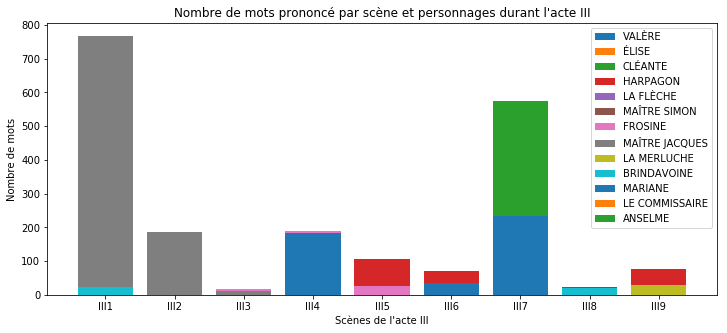

In [27]:
def plot_acte(acte):
    df=donnee(acte)
    fig, ax = plt.subplots()
    for k in range(0,len(list_perso)):
        ax.bar(LSigleA(acte), df[k], label=list_perso[k])
    ax.set_xlabel("Scènes de l'acte "+roman_num(acte))
    ax.set_ylabel("Nombre de mots")
    ax.set_title("Nombre de mots prononcé par scène et personnages durant l'acte "+roman_num(acte))
    ax.legend()
    plt.show()
    return None
plt.rcParams['figure.figsize'] = [12, 5]
plot_acte(3)

On peut évidemment réaliser le même rendu pour tous les actes :

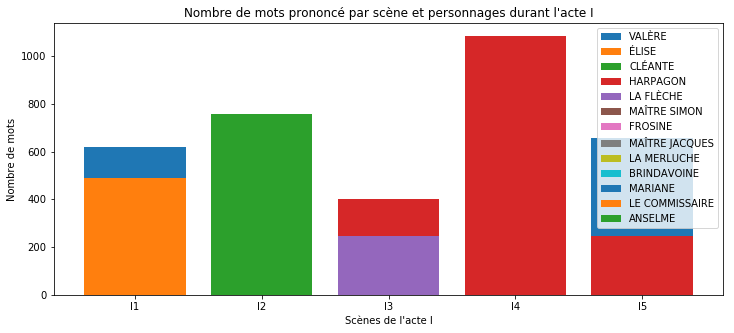

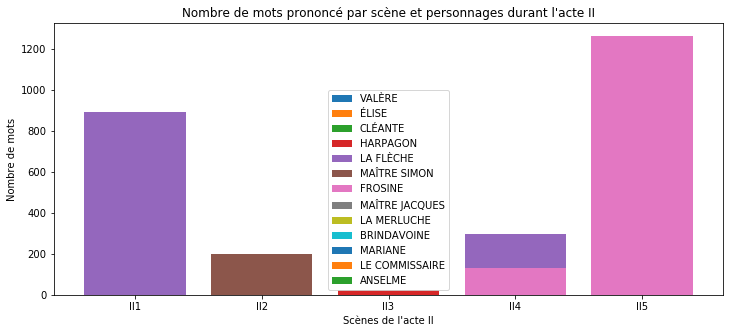

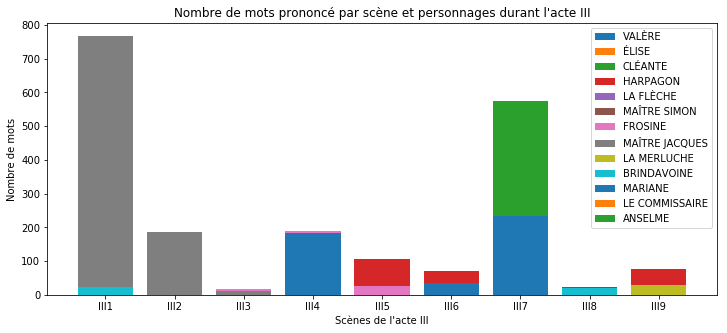

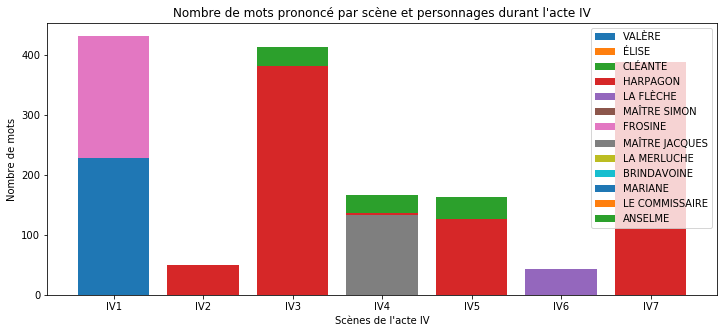

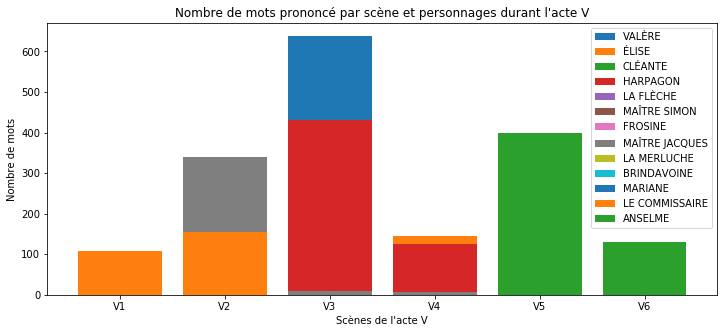

In [28]:
plt.rcParams['figure.figsize'] = [12, 5]
for k in range(1,6):
    plot_acte(k)

On peut alors tout de suite analyser le texte avec beaucoup plus de précision. Par exemple :
1. Harpagon semble énoncer un monologue à la scène 4 de l'acte I.
2. Il est quasiment absent de l'acte II.
3. Le record de la scène la plus longue semble être tenu par _II5_, et Frosine y monopolise la parole.

# Graphe des interlocuteurs

__Consignes :__ ( _facultatif_ ) construisez un graphe d’interlocution permettant de visualiser les échanges entre les personnages.

On introduit un nouveau package :

In [29]:
import networkx as nx

On va parcourir les répliques, et estimer que deux personnages s'adressent une fois la paroles si l'un parle immédiatement après l'autre ( _cette convention est évidemment source de nombreuses critiques_ )

In [30]:
G=nx.Graph()
G.add_nodes_from(list_perso)
for i in range(0,len(list_perso)-1):
    for j in range(i+1,len(list_perso)):
        w=0
        perso1=list_perso[i]
        perso2=list_perso[j]
        for k in range(0,len(repliques[:-1])):
            if repliques[k][1]==perso1 and repliques[k+1][1]==perso2:
                w+=1
        G.add_edge(perso1,perso2,weight=w)

On observe qu'__Harapagon__ se retrouve à nouveau au centre de l'attention, proche entre autres de __Cléante__ :

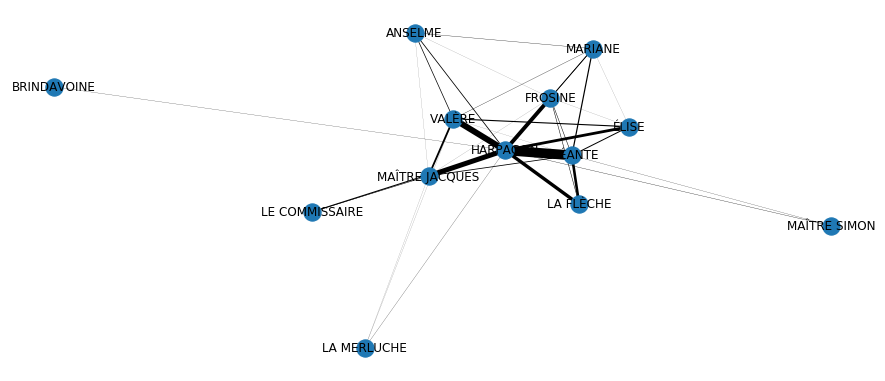

In [31]:
weights = [G[u][v]['weight']/10 for u,v in G.edges()]
nx.draw(G, width=weights,with_labels=True)

Cette représentation graphique marque la fin de notre analyse de données.